In [1]:
## import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import pyspark.sql.functions as f
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
# Import all functions from pyspark.sql.functions, including col etc to manipulate columns
from pyspark.sql.functions import *
# Vector Assembler
from pyspark.ml.feature import VectorAssembler
# Linear Regression Analysis
from pyspark.ml.regression import LinearRegression
# Standardisation
from pyspark.ml.feature import StandardScaler
# StringIndexer
from pyspark.ml.feature import *
# RegressionEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
#Param Grid Search libraries
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

In [2]:
!hdfs dfs -put /home/master/Downloads/LC

In [3]:
!hdfs dfs -ls LC

Found 4 items
-rw-r--r--   1 master supergroup   48669611 2019-02-15 19:28 LC/LoanStats_2017Q1.csv
-rw-r--r--   1 master supergroup   53047611 2019-02-15 19:28 LC/LoanStats_2017Q2.csv
-rw-r--r--   1 master supergroup   61960082 2019-02-15 19:28 LC/LoanStats_2017Q3.csv
-rw-r--r--   1 master supergroup   59676775 2019-02-15 19:28 LC/LoanStats_2017Q4.csv


In [2]:
loans = spark.read.format("com.databricks.spark.csv")\
.option("header", "true")\
.option("inferSchema", "true").\
load(["hdfs://localhost:8020/user/master/LC/LoanStats_2017Q1.csv",
     "hdfs://localhost:8020/user/master/LC/LoanStats_2017Q2.csv",
     "hdfs://localhost:8020/user/master/LC/LoanStats_2017Q3.csv",
     "hdfs://localhost:8020/user/master/LC/LoanStats_2017Q4.csv"])

In [3]:
# type
type(loans)

pyspark.sql.dataframe.DataFrame

In [3]:
loans.count()

443080

In [6]:
# in-memory-usage
loans.cache()

DataFrame[id: string, member_id: string, loan_amnt: string, funded_amnt: string, funded_amnt_inv: string, term: string, int_rate: string, installment: string, grade: string, sub_grade: string, emp_title: string, emp_length: string, home_ownership: string, annual_inc: string, verification_status: string, issue_d: string, loan_status: string, pymnt_plan: string, url: string, desc: string, purpose: string, title: string, zip_code: string, addr_state: string, dti: string, delinq_2yrs: string, earliest_cr_line: string, inq_last_6mths: string, mths_since_last_delinq: string, mths_since_last_record: string, open_acc: string, pub_rec: string, revol_bal: string, revol_util: string, total_acc: string, initial_list_status: string, out_prncp: string, out_prncp_inv: string, total_pymnt: string, total_pymnt_inv: string, total_rec_prncp: string, total_rec_int: string, total_rec_late_fee: string, recoveries: string, collection_recovery_fee: string, last_pymnt_d: string, last_pymnt_amnt: string, next_p

In [3]:
loans.createOrReplaceTempView("loans")

In [8]:
spark.sql("SELECT * FROM loans LIMIT 1").show(n=1)

+----+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------+----------+--------------+----------+-------------------+--------+-----------+----------+----+----+------------------+------------------+--------+----------+----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+----------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+---

In [21]:
spark.sql("SELECT * FROM loans LIMIT 5").toPandas().head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term;,_c145,_c146,_c147
0,None,None,16000,16000,16000,60,12.74,361.93,C,C1,...,N,None,None,None,None,None,;,None,None,None
1,None,None,11875,11875,11875,36,11.44,391.26,B,B4,...,N,None,None,None,None,None,;,None,None,None
2,None,None,12000,12000,12000,36,7.99,375.99,A,A5,...,N,None,None,None,None,None,;,None,None,None
3,None,None,25000,25000,25000,36,15.99,878.81,C,C5,...,N,None,None,None,None,None,;,None,None,None
4,None,None,1500,1500,1500,36,5.32,45.18,A,A1,...,N,None,None,None,None,None,;,None,None,None


In [4]:
loans_a = loans['int_rate','loan_amnt','term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc','verification_status','purpose','addr_state', 'open_acc']

In [5]:
loans_a = loans_a.withColumn("loan_amnt", loans_a["loan_amnt"].cast(IntegerType()))
loans_a = loans_a.withColumn("term", loans_a["term"].cast(IntegerType()))
loans_a = loans_a.withColumn("emp_length", loans_a["emp_length"].cast(IntegerType()))
loans_a = loans_a.withColumn("annual_inc", loans_a["annual_inc"].cast(IntegerType()))
loans_a = loans_a.withColumn("open_acc", loans_a["open_acc"].cast(IntegerType()))
loans_a = loans_a.withColumn("int_rate", loans_a["int_rate"].cast(IntegerType()))

In [11]:
loans_a.toPandas().head(5)

,int_rate,loan_amnt,term,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,open_acc
0,20,2800,36,D,D4,0,MORTGAGE,1,Not Verified,debt_consolidation,PA,13
1,10,11000,36,B,B4,0,MORTGAGE,1,Not Verified,debt_consolidation,FL,14
2,24,19200,60,E,E3,0,MORTGAGE,1,Not Verified,debt_consolidation,IN,11
3,19,25000,60,D,D3,0,MORTGAGE,1,Not Verified,debt_consolidation,PA,13
4,7,20000,36,A,A4,0,RENT,1,Not Verified,debt_consolidation,NY,8


In [12]:
loans_a.printSchema()

root
 |-- int_rate: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- term: integer (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: integer (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: integer (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- open_acc: integer (nullable = true)



In [13]:
#missing value analysis
loans_a_pd = loans_a.toPandas()
loans_a_pd.isnull().sum()

int_rate               0
loan_amnt              0
term                   0
grade                  0
sub_grade              0
emp_length             0
home_ownership         0
annual_inc             0
verification_status    0
purpose                0
addr_state             0
open_acc               0
dtype: int64

In [14]:
# descriptive stats on the data
loans_a.describe().toPandas()

,summary,int_rate,loan_amnt,term,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,open_acc
0,count,443080,443080,443080,443080,443080,443080,443080,443080,443080,443080,443080,443080
1,mean,12.718466191207005,14841.138676988354,42.66050374650176,None,None,5.483576329331046,None,80194.4396610093,None,None,None,11.62047937167103
2,stddev,5.203642966740987,9630.427292613873,10.746629258128982,None,None,3.8227612307124237,None,204202.90394065322,None,None,None,5.789256580291201
3,min,5,1000,36,A,A1,0,ANY,0,Not Verified,car,AK,0
4,max,30,40000,60,G,G5,10,RENT,110000000,Verified,wedding,WY,93


In [6]:
# Transform and add to df
loans_a = loans_a.withColumn('loan_amnt_tsd', col('loan_amnt')/1000)
loans_a = loans_a.withColumn('annual_inc_tsd', col('annual_inc')/1000)

In [7]:
# ADD Polynomials degree = 2, square annual_inc and loan_amnt 
loans_a = loans_a.withColumn('loan_amnt_poly', (col('loan_amnt_tsd') * col('loan_amnt_tsd')))
loans_a = loans_a.withColumn('annual_inc_poly',(col('annual_inc_tsd') * col('annual_inc_tsd')))

In [8]:
# z-Standardisation
loans_a = loans_a.withColumn('loan_amnt_zstand', (col('loan_amnt')-14841.13)/9630.42)
loans_a = loans_a.withColumn('annual_inc_zstand', (col('annual_inc')-80194.43)/204202.90)

In [9]:
loans_a.printSchema()

root
 |-- int_rate: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- term: integer (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: integer (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: integer (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- open_acc: integer (nullable = true)
 |-- loan_amnt_tsd: double (nullable = true)
 |-- annual_inc_tsd: double (nullable = true)
 |-- loan_amnt_poly: double (nullable = true)
 |-- annual_inc_poly: double (nullable = true)
 |-- loan_amnt_zstand: double (nullable = true)
 |-- annual_inc_zstand: double (nullable = true)



In [10]:
# TempView
loans_a.createOrReplaceTempView("loans_a")

In [23]:
loans_b = spark.sql("SELECT int_rate, LOG(loan_amnt_tsd) AS loan_amnt_ln, LOG(annual_inc_tsd) AS annual_inc_ln, \
                       LOG(loan_amnt_poly) AS loan_amnt_pln, LOG(annual_inc_poly) AS annual_inc_pln, \
                       emp_length, grade, sub_grade, home_ownership, verification_status, purpose, addr_state, \
                       open_acc, term FROM loans_a")

In [24]:
loans_b.cache()

DataFrame[int_rate: int, loan_amnt_ln: double, annual_inc_ln: double, loan_amnt_pln: double, annual_inc_pln: double, emp_length: int, grade: string, sub_grade: string, home_ownership: string, verification_status: string, purpose: string, addr_state: string, open_acc: int, term: int]

In [25]:
loans_b.createOrReplaceTempView("loans_b")

In [14]:
loans_b.toPandas().head(3)

,int_rate,loan_amnt_ln,annual_inc_ln,loan_amnt_pln,annual_inc_pln,emp_length,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,open_acc,term
0,20,1.029619,-6.907755,2.059239,-13.815511,0,D,D4,MORTGAGE,Not Verified,debt_consolidation,PA,13,36
1,10,2.397895,-6.907755,4.795791,-13.815511,0,B,B4,MORTGAGE,Not Verified,debt_consolidation,FL,14,36
2,24,2.954910,-6.907755,5.909821,-13.815511,0,E,E3,MORTGAGE,Not Verified,debt_consolidation,IN,11,60


In [26]:
stringIndexer = StringIndexer(inputCol='home_ownership', outputCol='home_ownership_num')
model = stringIndexer.fit(loans_b)
loans_b = model.transform(loans_b)

stringIndexer = StringIndexer(inputCol='verification_status', outputCol='verification_status_num')
model = stringIndexer.fit(loans_b)
loans_b = model.transform(loans_b)

stringIndexer = StringIndexer(inputCol='addr_state', outputCol='addr_state_num')
model = stringIndexer.fit(loans_b)
loans_b = model.transform(loans_b)

stringIndexer = StringIndexer(inputCol='purpose', outputCol='purpose_num')
model = stringIndexer.fit(loans_b)
loans_b = model.transform(loans_b)

stringIndexer = StringIndexer(inputCol='grade', outputCol='grade_num')
model = stringIndexer.fit(loans_b)
loans_b = model.transform(loans_b)

## SUB_GRADE REMOVED FROM MODELING DUE TO SYSTEM CRASH
#stringIndexer = StringIndexer(inputCol='sub_grade', outputCol='sub_grade_num')
#model = stringIndexer.fit(loans_b)
#loans_b = model.transform(loans_b)

#loans_b.toPandas().head(5)

In [27]:
# setup OneHotEncoder
encoder = OneHotEncoder(inputCol='home_ownership_num', outputCol='home_ownership_cat') # dropLast = False
# apply to data
loans_b = encoder.transform(loans_b)


encoder = OneHotEncoder(inputCol='verification_status_num', outputCol='verification_status_cat') # dropLast = False
loans_b = encoder.transform(loans_b)

encoder = OneHotEncoder(inputCol='addr_state_num', outputCol='addr_state_cat') # dropLast = False
loans_b = encoder.transform(loans_b)

encoder = OneHotEncoder(inputCol='purpose_num', outputCol='purpose_cat') # dropLast = False
loans_b = encoder.transform(loans_b)

encoder = OneHotEncoder(inputCol='grade_num', outputCol='grade_cat') # dropLast = False
loans_b = encoder.transform(loans_b)

## SUB_GRADE REMOVED FROM MODELING DUE TO SYSTEM CRASH
#encoder = OneHotEncoder(inputCol='sub_grade_num', outputCol='sub_grade_cat') # dropLast = False
#loans_b = encoder.transform(loans_b)

#loans_b.toPandas().head(5)

In [28]:
# Initalize
vectorAssembler = VectorAssembler(inputCols = ['loan_amnt_ln','term', 'grade_cat', 'addr_state_cat', 'emp_length', \
                                               'home_ownership_cat', 'annual_inc_ln','verification_status_cat', \
                                               'purpose_cat', 'open_acc'], 
                                  outputCol = 'features')
loans_b_ml = vectorAssembler.setHandleInvalid("skip").transform(loans_b)
loans_b_ml.printSchema()

root
 |-- int_rate: integer (nullable = true)
 |-- loan_amnt_ln: double (nullable = true)
 |-- annual_inc_ln: double (nullable = true)
 |-- loan_amnt_pln: double (nullable = true)
 |-- annual_inc_pln: double (nullable = true)
 |-- emp_length: integer (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- open_acc: integer (nullable = true)
 |-- term: integer (nullable = true)
 |-- home_ownership_num: double (nullable = false)
 |-- verification_status_num: double (nullable = false)
 |-- addr_state_num: double (nullable = false)
 |-- purpose_num: double (nullable = false)
 |-- grade_num: double (nullable = false)
 |-- home_ownership_cat: vector (nullable = true)
 |-- verification_status_cat: vector (nullable = true)
 |-- addr_state_cat: vector (nullable = true)
 |-- p

In [29]:
loans_b_mll = loans_b_ml.select('features',col('int_rate').alias('label'))

In [30]:
loans_b_mll.toPandas().head(5)

,features,label
0,"(1.0296194171811581, 36.0, 0.0, 0.0, 0.0, 1.0,...",20
1,"(2.3978952727983707, 36.0, 0.0, 1.0, 0.0, 0.0,...",10
2,"(2.954910279033736, 60.0, 0.0, 0.0, 0.0, 0.0, ...",24
3,"(3.2188758248682006, 60.0, 0.0, 0.0, 0.0, 1.0,...",19
4,"(2.995732273553991, 36.0, 0.0, 0.0, 1.0, 0.0, ...",7


In [31]:
training_data, test_data = loans_b_mll.randomSplit(weights=[.7,.3], seed=25)

In [18]:
training_data.count()

310071

In [19]:
test_data.count()

133008

In [33]:
#Step 1: Initialize the linear regression
lr_cat = LinearRegression(maxIter=100)
# Parametrization for a classical linear regression

In [34]:
#ParamGrid search - Total 2 * 2 * 3 = 12 combinations of parameters will be evaluated and the bst chosen
ParamGrid = ParamGridBuilder() \
            .addGrid(lr_cat.regParam, [0.1, 0.01]) \
            .addGrid(lr_cat.fitIntercept, [True, False]) \
            .addGrid(lr_cat.elasticNetParam, [0.0, 0.5, 1.0]) \
            .build()

In [35]:
#TrainValidation Split
tvs = TrainValidationSplit(estimator=lr_cat,
                           estimatorParamMaps=ParamGrid,
                           evaluator=RegressionEvaluator(),
                           trainRatio=0.8)

In [36]:
linearModel_grid = tvs.fit(training_data)

In [44]:
linearModel_grid.bestModel.coefficients

DenseVector([0.0024, 0.0125, -13.6122, -17.358, -20.7202, -9.0358, -3.4314, 1.5157, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0292, 0.029, 0.0, 0.0, -0.1167, -0.0325, -0.2333, 0.0135, -0.0534, -0.0078, 0.0202, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

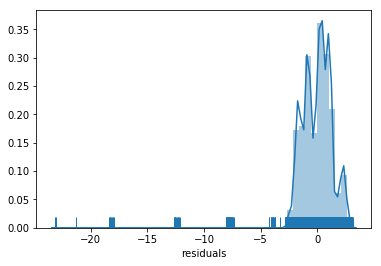

In [45]:
# residuals
lr_residuals = linearModel_grid.bestModel.summary.residuals.toPandas()
sns.distplot(a=lr_residuals['residuals'], rug = True)

In [40]:
predictions_lr = linearModel_grid.transform(test_data)
predictions_lr.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)
 |-- prediction: double (nullable = false)



In [41]:
predictions_lr.toPandas().head(50)

,features,label,prediction
0,"(1.2809338454620642, 36.0, 1.0, 0.0, 0.0, 0.0,...",15,13.671543
1,"(1.4929040961781488, 36.0, 1.0, 0.0, 0.0, 0.0,...",16,13.633717
2,"(1.6094379124341003, 36.0, 1.0, 0.0, 0.0, 0.0,...",13,13.723606
3,"(1.6094379124341003, 36.0, 1.0, 0.0, 0.0, 0.0,...",13,13.710309
4,"(1.6094379124341003, 36.0, 1.0, 0.0, 0.0, 0.0,...",16,13.852618
5,"(1.6094379124341003, 36.0, 1.0, 0.0, 0.0, 0.0,...",16,13.698373
6,"(1.9740810260220096, 36.0, 1.0, 0.0, 0.0, 0.0,...",12,13.630297
7,"(2.0794415416798357, 36.0, 1.0, 0.0, 0.0, 0.0,...",14,13.667153
8,"(2.302585092994046, 36.0, 1.0, 0.0, 0.0, 0.0, ...",16,13.747533
9,"(2.302585092994046, 36.0, 1.0, 0.0, 0.0, 0.0, ...",13,13.745906


In [42]:
evaluator = RegressionEvaluator(metricName="r2",labelCol='label')

In [43]:
evaluator.evaluate(predictions_lr)

0.9465546882486311